In [221]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go
import math as mth
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Paso 1. Abrir el archivo de datos y leer la información general

In [222]:
logs = pd.read_csv(
    'logs_exp_us.csv', 
    sep='\s',
    engine='python',
    header=0,
    dtype={'EventName': 'category', 'ExpId': 'category'}
    )


<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\supercash\AppData\Local\Temp\ipykernel_17732\1200351513.py:3: SyntaxWarning:

invalid escape sequence '\s'



In [223]:
display(logs.head())
logs.info(memory_usage='deep')

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


# Paso 2. Preparar los datos para el análisis

In [224]:
logs.columns = ['event_name', 'user_id', 'full_date', 'group']
logs.head()

,event_name,user_id,full_date,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [225]:
print(logs.duplicated().sum())

413


In [226]:
#elimino duplicados
logs.drop_duplicates(inplace=True)
logs.reset_index(inplace=True, drop=True)
print(logs.duplicated().sum())

0


In [227]:
logs['full_date'] = pd.to_datetime(logs['full_date'], unit='s')
logs.head()

,event_name,user_id,full_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [228]:
logs['fecha'] = logs['full_date'].dt.date
logs['hora'] = logs['full_date'].dt.time
logs.head()

,event_name,user_id,full_date,group,fecha,hora
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


# Paso 3. Estudiar y comprobar los datos

In [229]:
# caunto tipos de eventos hay
print(logs['event_name'].nunique())
print(logs['event_name'].unique())

5
['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']


In [230]:
#cauntos usuarios hay
logs['user_id'].nunique()

7551

In [231]:
print('promedio de eventos por usuario:', (logs.shape[0]/logs['user_id'].nunique()))

promedio de eventos por usuario: 32.27559263673685


¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [232]:
# primera y ultima fecha
print(logs['fecha'].min(), logs['fecha'].max())

2019-07-25 2019-08-07


<Axes: xlabel='fecha'>

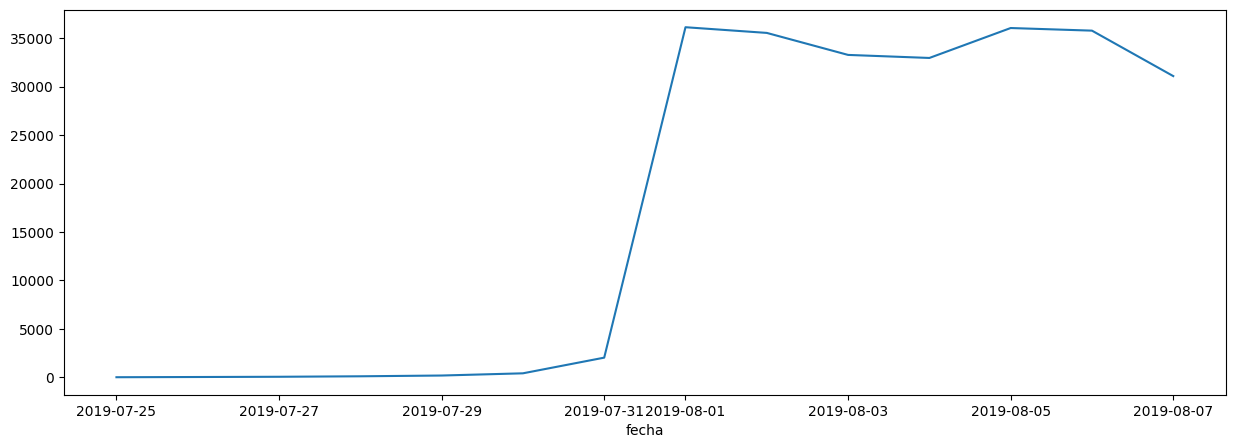

In [233]:

plt.figure(figsize=(15,5))
logs.groupby('fecha')['user_id'].count().plot()

In [234]:
# se filtra por la fecha del 31 de julio
logs_filtrados = logs[logs['fecha'] > pd.to_datetime('2019-07-31').date()]
logs_filtrados.head()

,event_name,user_id,full_date,group,fecha,hora
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [235]:
# proporcion de usuarios despues del filtro
logs_filtrados['user_id'].nunique() / logs['user_id'].nunique()

0.9977486425638988

In [236]:
# proporcion del eventos despues del filtro
len(logs_filtrados) / len(logs)

0.988404393692581

In [237]:
#usuarios por grupo
users_per_group = logs_filtrados.groupby('group')['user_id'].count()
users_per_group

C:\Users\supercash\AppData\Local\Temp\ipykernel_17732\267425225.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



group
246    79302
247    77022
248    84563
Name: user_id, dtype: int64

# Paso 4. Estudiar el embudo de eventos

In [238]:
# envudo por eventos
logs_filtrados.groupby('event_name')['user_id'].count().sort_values(ascending=False)

C:\Users\supercash\AppData\Local\Temp\ipykernel_17732\4247163357.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

In [239]:
# enbudo por usuarios
logs_filtrados.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

C:\Users\supercash\AppData\Local\Temp\ipykernel_17732\3656645413.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

en que orden ocurren los eventos

In [240]:
user_by_event = logs_filtrados.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
user_by_event['users_in_ps'] = user_by_event['user_id'].shift(1)
user_by_event['cr_ps'] = user_by_event['user_id'] / user_by_event['users_in_ps']
user_by_event['dropoff_rate'] = 1 - user_by_event['cr_ps']

user_by_event.head()


C:\Users\supercash\AppData\Local\Temp\ipykernel_17732\4066831154.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,event_name,user_id,users_in_ps,cr_ps,dropoff_rate
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


In [241]:
fig = go.Figure(go.Funnel(
    y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
    x = [7419, 4593	, 3734, 3539],
    textinfo = 'value+percent initial'
))
fig.show()

# Paso 5. Estudiar los resultados del experimento

In [242]:
users_per_group

group
246    79302
247    77022
248    84563
Name: user_id, dtype: int64

In [243]:
logs_filtrados.head()

,event_name,user_id,full_date,group,fecha,hora
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [244]:
base_conver = logs_filtrados[['user_id', 'group']].drop_duplicates()
base_conver.head()

,user_id,group
2826,3737462046622621720,246
2830,1433840883824088890,247
2831,4899590676214355127,247
2838,1182179323890311443,246
2842,4613461174774205834,248


In [245]:
converted = pd.DataFrame(data = {
    'user_id': logs_filtrados[logs_filtrados['event_name'] == 'PaymentScreenSuccessful' ]['user_id'].unique(),
    'converted': 1
})
converted

,user_id,converted
0,4613461174774205834,1
1,2712290788139738557,1
2,6049698452889664846,1
3,5653442602434498252,1
4,6126676435667432321,1
...,...,...
3534,4369662623769092250,1
3535,4876403292056911122,1
3536,1309234519709630135,1
3537,7823752606740475984,1


In [246]:
payment_conversion = base_conver.merge(converted, on='user_id', how='left')
payment_conversion['converted'] = payment_conversion['converted'].fillna(0)
payment_conversion

,user_id,group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


H0: la tasa de conversion de los grupos 246 y 247 son iguales.

HA: la tasa de conversion de los grupos 246 y 247 sin diferentes.

significancia $\alpha$ = 0.1

In [247]:
group_246 = payment_conversion[payment_conversion['group'] == '246']['converted']
group_247 = payment_conversion[payment_conversion['group'] == '247']['converted']


In [248]:
alpha = 0.1

tabla = [[group_246.sum(), len(group_246)],
         [group_247.sum(), len(group_247)]]

chi2, p_value, dof, expected = chi2_contingency(tabla)

if p_value < alpha:
    
    print('se rechaza la hipotesis nula')
else:
    print(('no rechazamos la hipotesis nula'))

no rechazamos la hipotesis nula


In [249]:
main_conv= pd.DataFrame(data = {
    'user_id': logs_filtrados[logs_filtrados['event_name'] == 'MainScreenAppear' ]['user_id'].unique(),
    'converted': 1
})
main_conv
main_screen_conv =  base_conver.merge(main_conv, on='user_id', how='left')
main_screen_conv['converted'] = main_screen_conv['converted'].fillna(0)


main_screen_246 = main_screen_conv[main_screen_conv['group'] == '246']['converted']
main_screen_247 = main_screen_conv[main_screen_conv['group'] == '247']['converted']

tabla_main = [[main_screen_246.sum(), len(main_screen_246)],
         [main_screen_247.sum(), len(main_screen_247)]]

chi2, p_value_main, dof, expected = chi2_contingency(tabla_main)

if p_value_main < alpha:
    
    print('se rechaza la hipotesis nula')
else:
    print(('no rechazamos la hipotesis nula'))


no rechazamos la hipotesis nula


In [250]:
def prueba_proporcion_control (event):
    conver = pd.DataFrame(data={
        'user_id': logs_filtrados[logs_filtrados['event_name'] == event]['user_id'].unique(),
        'converted' : 1
    })
    event_conv = base_conver.merge(conver, on='user_id', how='left')
    event_conv['converted'] = event_conv['converted'].fillna(0)

    event_246 = event_conv[event_conv['group'] == '246']['converted']
    event_247 = event_conv[event_conv['group'] == '247']['converted']
    
    tabla_event = [[event_246.sum(), len(event_246)],
                 [event_247.sum(), len(event_247)]]
    
    _, event_pvalue, _, _ = chi2_contingency(tabla_event)
    if event_pvalue < alpha:
        print(f'para el evento {event}: se rechaza la hipotesis nula, el valor p es: {event_pvalue}')
        return event_pvalue
    else:
        print(f'para el evento {event}: no podemos rechazar la hipotesis nula, el valor p es: {event_pvalue}')
        return event_pvalue

In [251]:
events = logs_filtrados['event_name'].unique()

In [252]:
#aqui declaro mi array para mas adelantes en la correccion
p_values = []

In [253]:

for event in events:
    p = prueba_proporcion_control(event)
    p_values.append(p)

para el evento Tutorial: no podemos rechazar la hipotesis nula, el valor p es: 0.9798154716151751
para el evento MainScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.9951421638422977
para el evento OffersScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.5871369576812819
para el evento CartScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.5033362772681892
para el evento PaymentScreenSuccessful: no podemos rechazar la hipotesis nula, el valor p es: 0.35745591739900373


los grupos de control son estadisticamente iguales segun los datos que tenemos

In [254]:
def prueba_proporcion_246_248 (event):
    conver = pd.DataFrame(data={
        'user_id': logs_filtrados[logs_filtrados['event_name'] == event]['user_id'].unique(),
        'converted' : 1
    })
    event_conv = base_conver.merge(conver, on='user_id', how='left')
    event_conv['converted'] = event_conv['converted'].fillna(0)

    event_246 = event_conv[event_conv['group'] == '246']['converted']
    event_248 = event_conv[event_conv['group'] == '248']['converted']
    
    tabla_event = [[event_246.sum(), len(event_246)],
                 [event_248.sum(), len(event_248)]]
    
    _, event_pvalue, _, _ = chi2_contingency(tabla_event)
    if event_pvalue < alpha:
        print(f'para el evento {event}: se rechaza la hipotesis nula, el valor p es: {event_pvalue}')
        return event_pvalue
    else:
        print(f'para el evento {event}: no podemos rechazar la hipotesis nula, el valor p es: {event_pvalue}')
        return event_pvalue

In [255]:
for event in events:
    p1 = prueba_proporcion_246_248(event)
    p_values.append(p1)

para el evento Tutorial: no podemos rechazar la hipotesis nula, el valor p es: 0.8795777904028355
para el evento MainScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.9421074225649605
para el evento OffersScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.55233542728455
para el evento CartScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.31952683422400363
para el evento PaymentScreenSuccessful: no podemos rechazar la hipotesis nula, el valor p es: 0.47150261305894936


estadisticamente el grupo de control 246 y el grupo con feuntes alteradas son iguales.

In [256]:
def prueba_proporcion_247_248 (event):
    conver = pd.DataFrame(data={
        'user_id': logs_filtrados[logs_filtrados['event_name'] == event]['user_id'].unique(),
        'converted' : 1
    })
    event_conv = base_conver.merge(conver, on='user_id', how='left')
    event_conv['converted'] = event_conv['converted'].fillna(0)

    event_247 = event_conv[event_conv['group'] == '247']['converted']
    event_248 = event_conv[event_conv['group'] == '248']['converted']
    
    tabla_event = [[event_247.sum(), len(event_247)],
                 [event_248.sum(), len(event_248)]]
    
    _, event_pvalue, _, _ = chi2_contingency(tabla_event)
    if event_pvalue < alpha:
        print(f'para el evento {event}: se rechaza la hipotesis nula, el valor p es: {event_pvalue}')
        return event_pvalue
    else:
        print(f'para el evento {event}: no podemos rechazar la hipotesis nula, el valor p es: {event_pvalue}')      
        return event_pvalue

In [257]:
for event in events:
    p2 = prueba_proporcion_247_248(event)
    p_values.append(p2)

para el evento Tutorial: no podemos rechazar la hipotesis nula, el valor p es: 0.8239504733109657
para el evento MainScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.9627978201287546
para el evento OffersScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.9783826267078107
para el evento CartScreenAppear: no podemos rechazar la hipotesis nula, el valor p es: 0.7634722522512674
para el evento PaymentScreenSuccessful: no podemos rechazar la hipotesis nula, el valor p es: 0.8586175986996458


estadísticamente el grupo de control 247 y el grupo con fuentes alteradas son iguales.

el cambio en las fuentes no parece haber generados ningún cambio en el comportamiento de los usuarios

Hice 15 pruebas de hipótesis con el nivel de significancia de 0.1 por lo que estadísticamente me equivoqué en al menos una, hay que cambiar el nivel de significancia. 

Para mejorar El nivel de significancia para mejorar la confiabilidad  aplicamos el método holm-Bonferroni 

In [258]:
from multipy.fwer import holm_bonferroni

In [ ]:
p_values = np.array(p_values)
p_values

array([0.97981547, 0.99514216, 0.58713696, 0.50333628, 0.35745592,
       0.87957779, 0.94210742, 0.55233543, 0.31952683, 0.47150261,
       0.82395047, 0.96279782, 0.97838263, 0.76347225, 0.8586176 ])

In [266]:
df = pd.DataFrame(p_values, columns=['p_value'])
df['hypothesis_correction_result'] = holm_bonferroni(p_values, alpha)
df

,p_value,hypothesis_correction_result
0,0.979815,False
1,0.995142,False
2,0.587137,False
3,0.503336,False
4,0.357456,False
5,0.879578,False
6,0.942107,False
7,0.552335,False
8,0.319527,False
9,0.471503,False


Del índice 0 a 4 son de las pruebas entre los grupos de control, del 5 al 9 son de las pruebas entre el grupo de control 246 y el grupo con fuentes modificadas y las 5 restantes son entre el grupo de control 247 y el grupo con fuentes modificadas

# Conclusión

Aun después de la corrección todas las pruebas de hipótesis siguen sin poder rechazarla hipótesis nula, por lo que podemos afirmar que las proporciones son estadísticamente iguales, esto quiere decir que los cambios en las fuentes no generaron un cambio en las tazas de conversión.